In [ ]:
%pip install xgboost
%pip install tensorflow

In [34]:
import pandas as pd
import numpy as np
import json
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import sys
sys.path.append("../utils")
import joblib

from utils import load_csv
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
symbols = ["fpt", "hpg", "vnm"]
dfs = {s: load_csv(f"../../data/features/{s}_features.csv") for s in symbols}
feature_cols = [
    "open", "high", "low", "close", "volume",
    "EMA_9", "SMA_5", "SMA_10", "SMA_15", "SMA_30", "RSI14", "MACD"
]

2025-06-08 00:47:47,210 - INFO - ✅ Load CSV thành công: ../../data/features/fpt_features.csv | shape = (4521, 13)
2025-06-08 00:47:47,223 - INFO - ✅ Load CSV thành công: ../../data/features/hpg_features.csv | shape = (4318, 13)
2025-06-08 00:47:47,236 - INFO - ✅ Load CSV thành công: ../../data/features/vnm_features.csv | shape = (4753, 13)


In [53]:
df = load_csv("../../data/features/hpg_features.csv")

2025-06-08 00:47:48,535 - INFO - ✅ Load CSV thành công: ../../data/features/hpg_features.csv | shape = (4318, 13)


In [54]:
df.index = df.date
df.drop('date',axis=1,inplace=True)
df

,open,high,low,close,volume,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI_14,MACD
date,,,,,,,,,,,,
2007-11-15,2.46,2.46,2.06,2.40,1306330,2.126301,2.172,2.102,2.063333,1.928333,82.089552,0.109193
2007-11-16,2.29,2.29,2.29,2.29,248510,2.085376,2.130,2.073,2.039333,1.912667,77.192982,0.091709
2007-11-19,2.17,2.17,2.17,2.17,120480,2.064220,2.108,2.056,2.017333,1.901333,74.000000,0.079259
2007-11-20,2.08,2.08,2.08,2.08,58710,2.060275,2.088,2.046,1.996000,1.893333,74.000000,0.074433
2007-11-21,1.98,2.16,1.98,2.16,728080,2.035343,2.060,2.027,1.970667,1.883000,90.000000,0.076354
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-21,27.10,27.25,27.05,27.15,18912200,25.979701,25.790,25.660,25.563333,25.628333,57.868020,0.271648
2025-03-24,27.15,27.25,26.90,27.15,16229800,25.687126,25.430,25.440,25.463333,25.578333,57.286432,0.181130
2025-03-25,27.25,27.40,27.10,27.20,20101000,25.308907,25.160,25.225,25.350000,25.525000,57.788945,0.062962


In [55]:
df1 = df.reset_index()['close']

In [ ]:
# chuẩn hoá dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
joblib.dump(scaler, "../../model/hpg_lstm_scaler.pkl")

['../../model/hpg_scaler.pkl']

In [57]:
split_index = int(len(df1)*0.7)
train_data, test_data = df1[:split_index], df1[split_index:]

In [58]:
def create_dataset(dataset, time_step = 50):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        dataX.append(dataset[i:(i+time_step),0])
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [59]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [60]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [61]:
# Khởi tạo mô hình
model = Sequential()

# Lớp 1
model.add(LSTM(units=128, return_sequences=True, input_shape=(100,1)))
model.add(Dropout(0.2))
# Lớp 2
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
# Lớp 3
model.add(LSTM(units=32))
model.add(Dropout(0.2))
# Lớp đầu ra
model.add(Dense(1))

# Compile mô hình với thuật toán tối ưu adam và đo hàm mất mát MAE
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 100, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 100, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,417 (501.63 KB)

 Trainable params: 128,417 (501.63 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
save_model_path = "../../model/hpg_lstm_model.keras"

# Lưu mô hình khi val_loss tốt hơn
best_model = ModelCheckpoint(
    filepath=save_model_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Dừng sớm nếu val_loss không cải thiện trong 20 epoch
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=64,
    verbose = 1,
    validation_data=(X_test, y_test),
    callbacks=[best_model, early_stop]
)

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0039
Epoch 1: val_loss improved from inf to 0.00589, saving model to ../../model/hpg_lstm_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - loss: 0.0038 - val_loss: 0.0059
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 3.4348e-04
Epoch 2: val_loss improved from 0.00589 to 0.00439, saving model to ../../model/hpg_lstm_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 3.4344e-04 - val_loss: 0.0044
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 3.0135e-04 
Epoch 3: val_loss did not improve from 0.00439
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 3.0090e-04 - val_loss: 0.0044
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 2.8035e-04
Epoch 4: val_loss did not improve from 0.00439
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - loss: 2.8058e-04 - val_loss: 0.0074
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 2.7832e-04
Epoch 5: val_loss did not improve from 0.00

In [63]:
final_model = load_model("../../model/hpg_lstm_model.keras")
train_predict = final_model.predict(X_train)
test_predict = final_model.predict(X_test)

92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [64]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

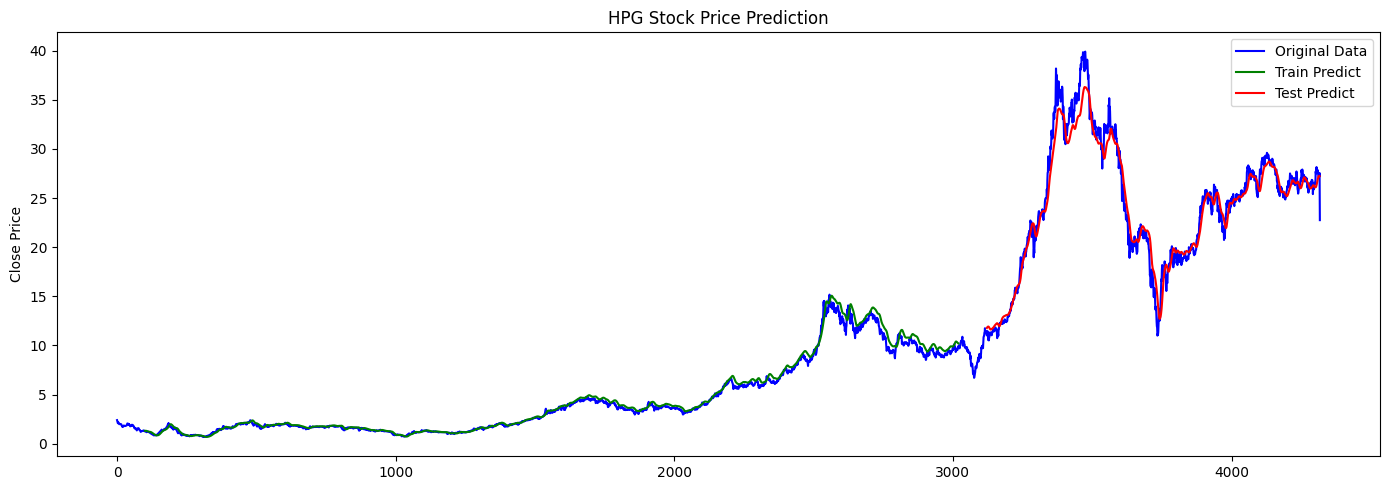

In [65]:
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
dates = df.index

testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
plt.figure(figsize=(14,5))
plt.plot(scaler.inverse_transform(df1), color='b', label='Original Data')
plt.plot(trainPredictPlot, color='g', label='Train Predict')
plt.plot(testPredictPlot, color='r', label='Test Predict')
plt.ylabel('Close Price')
plt.title('HPG Stock Price Prediction')
plt.legend()
plt.tight_layout()
plt.show()

In [66]:
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

In [67]:
mae = mean_absolute_error(y_test_inv, test_predict)
rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict))
mape = np.mean(np.abs((y_test_inv - test_predict) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, test_predict)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.2f}")

metrics = {
    "MAE": round(mae, 4),
    "RMSE": round(rmse, 4),
    "MAPE (%)": round(mape, 4),
    "R2": round(r2, 4)
}

with open("../../output/metrics/lstm_hpg_metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=4)


MAE: 0.98
RMSE: 1.36
MAPE: 4.11%
R²: 0.96
